In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [18]:
## Read the CSV File Using Pandas read_csv function
df = pd.read_csv('oasis_longitudinal.csv')



In [19]:
#print concise summery of the dataset
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [20]:
#since the dataset contain null values also 
#count total rows in each column which contain null values
df.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [21]:
#fill null value with their column mean and median
df["SES"].fillna(df["SES"].median(), inplace=True)
df["MMSE"].fillna(df["MMSE"].mean(), inplace=True)

<AxesSubplot:xlabel='Group', ylabel='count'>

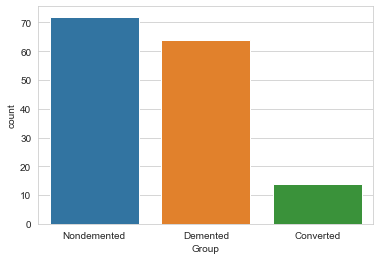

In [22]:
#see how many people have Alzheimer
#same person visits two or more time so only take the single visit data
sns.set_style("whitegrid")
ex_df = df.loc[df['Visit'] == 1]
sns.countplot(x='Group', data=ex_df)

<ipython-input-23-eb13ba819a5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex_df['Group'] = ex_df['Group'].replace(['Converted'], ['Demented'])


<AxesSubplot:xlabel='Group', ylabel='count'>

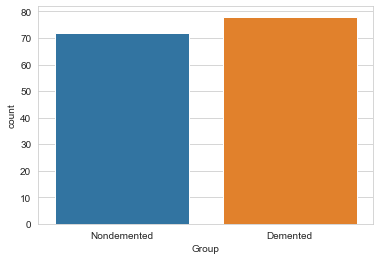

In [23]:
#We have three groups so convert Converted Group Into Demented

ex_df['Group'] = ex_df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
sns.countplot(x='Group', data=ex_df)

In [24]:
#convet the charecter data into numeric
group_map = {"Demented": 1, "Nondemented": 0}

df['Group'] = df['Group'].map(group_map)
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])

In [25]:
# Encode columns into numeric
from sklearn.preprocessing import LabelEncoder
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [26]:
from sklearn.model_selection import train_test_split

feature_col_names = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]
predicted_class_names = ['Group']

X = df[feature_col_names].values
y = df[predicted_class_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [27]:
from sklearn import metrics
'''
def roc_curves(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(predictions_test,y_test)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
'''
def roc_curves(model):
    y_probs = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(model.classes_)):
        fpr, tpr, _ = metrics.roc_curve(y_test == model.classes_[i], y_probs[:, i])
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc, model.classes_[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [28]:
total_models = ['SVC','XGBClassifier']
total_accuracy = {}
for i in total_models:
    total_accuracy[str(i)] = 0
def evalMetrics(model):
    pred = model.predict(X_test)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu)
    total_accuracy[str((str(model).split('(')[0]))] = accu
    precision = metrics.precision_score(y_test, pred, average='weighted',zero_division=0)
    recall = metrics.recall_score(y_test, pred, average='weighted',zero_division=0)
    f1_score = metrics.f1_score(y_test, pred, average='weighted')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)

In [29]:
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

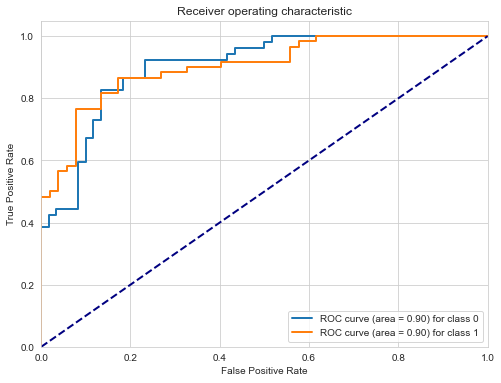


Acuuracy Of the Model:  0.8392857142857143
Precision: 0.8418367346938774
Recall: 0.8392857142857143
F1-score: 0.8394909688013136


In [30]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}
scoring = metrics.make_scorer(metrics.accuracy_score)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = scoring)
CV_rfc.fit(X_train, y_train.ravel())
#print(CV_rfc.best_params_)
#report_performance(CV_rfc) 
roc_curves(CV_rfc)
evalMetrics(CV_rfc)

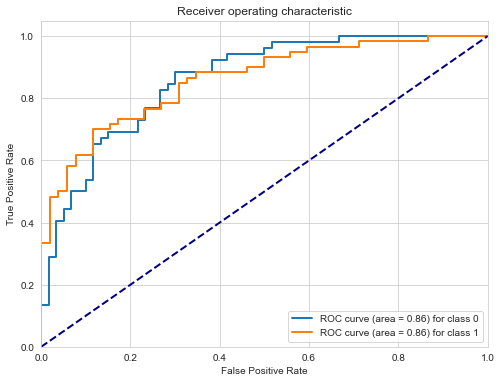


Acuuracy Of the Model:  0.7767857142857143
Precision: 0.7958966565349544
Recall: 0.7767857142857143
F1-score: 0.7756267616080701


In [31]:
svm = SVC(kernel="linear", C=0.1,random_state=0,probability=True)
svm.fit(X_train, y_train.ravel())
#report_performance(svm) 
roc_curves(svm)
evalMetrics(svm)

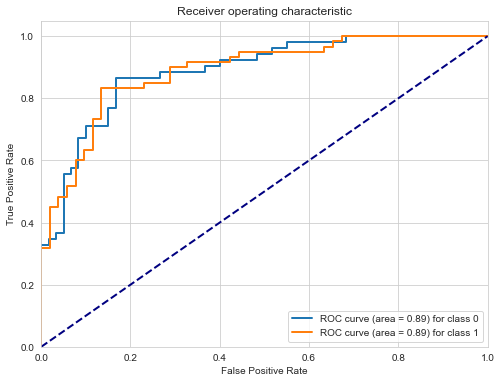


Acuuracy Of the Model:  0.8392857142857143
Precision: 0.8401295384054004
Recall: 0.8392857142857143
F1-score: 0.8394399013202979


In [32]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1,2,3,4,5]
        }

clf_xgb = XGBClassifier(random_state=0)
clf_xgb.fit(X_train, y_train.ravel())
#report_performance(clf_xgb) 
roc_curves(clf_xgb)
evalMetrics(clf_xgb)